In [1]:
# Imports
from PIL import Image, ImageOps
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Defining the diffusion function

Diffusion is used to encrypt the pixel data sequentially in a chained way using the chaotic Logistic Map equation-
$$
X_{n+1} = 4\lambda x_{n} (1-x_{n})
$$

$$
where \space 0.8925 \le \lambda \le 1 \space and \space 0 \le x_{n} \le 1
$$

#### How the diffusion function works?

Utilizing the chaotic logistic map equation, _x(n)_ and *l* values are determined under the relevant, previously specified constraints.

1. To find the *x(n+1)* or encrypted value for a given pixel, the `set_vals` method is used.
2. The function <code>set_vals</code> takes two values as parameters(_x_n, l, val_) where *l* is lambda and *val* is the pixel value from the _Original image_ data which is used for number of iterations and **returns** <code>targeted_value</code> for the corresponding pixel 
3. The next pixel data is encrypted using this encrypted value or `targeted_value` as x(n), and so on until all of the pixels are encrypted in a sequential manner.
4. The starting values of `x_c` and `l` are stored outside the loop, and the pixel data are iterated consecutively.
5. To track the number of times the final value is repeated over iterations, the `targeted_value` acquired for each original pixel data is recorded individually in a flat array (`iteration_history_data`). This information can be utilized for decrypting later on. 
6. The `targeted_value` is first multiplied by `10^17` to convert it from float to integer form, and then the <code>get_encrypted_pixel_val</code> function evaluates mod of `targeted_value` (integer form) to acquire the values between 0 and 255.
7. The encrypted image is formed by using the resultant acquired value as the encrypted pixel value.

In [2]:
def get_encrypted_pixel_val(x):
    return (x*pow(10, 17))%256

def set_vals(x_c, l, val, iteration_history):

    if (val==0):
        iteration_history.append(get_encrypted_pixel_val(x_c))
        return x_c
    else:
        for _ in range(val):
            x_val = (4*l*x_c)*(1-x_c)
            iteration_history.append(get_encrypted_pixel_val(x_val))
            
            x_c = x_val

        return x_val
    
# Main diffusion function
def diffuse_pixel(original_px_data, encrypted_px_data, history,  initial_x_c, initial_l):

    # Iterating over the pixel data sequentially
    for val in original_px_data:

        # Repeatation of final x in its respective iteration is stored in this list array
        iteration_history = []

        x = set_vals(initial_x_c, initial_l, val, iteration_history)
        encrypted_px_data.append(get_encrypted_pixel_val(x))
        history.append(iteration_history.count(get_encrypted_pixel_val(x)))

        # chaining the x_c
        initial_x_c = x



## Reading and Extracting Pixel values of the Original Image

In [3]:
with Image.open("./images/Lena-Image.png", mode='r') as im:

    # original image pixel data is stored in px_data 
    im = ImageOps.grayscale(im)
    px_data = list(im.getdata())

    print(f'Min: {min(px_data)}, Max: {max(px_data)}')
    print(f'Image resolution: WxH {im.size}\n')

im.close()

Min: 4, Max: 255
Image resolution: WxH (256, 256)



## STAGE 1: Applying diffusion to the original image data

In [4]:
# stores the corresponding encrypted pixel repeatation values
history = []

# encrypted pixel data is stored in this array list
encrypted_px_data = []

# Taking fixed values for x_c and l in the initial stage for decrpyting purposes
# x_c is x(n) and l is lambda
initial_x_c = 0.943625
initial_l = 0.9850

# applying the diffusion
diffuse_pixel(px_data, encrypted_px_data, history, initial_x_c, initial_l)

# Reshaping the flat array list into 256x256 to transform the encrypted pixel data back into image
a = np.reshape(encrypted_px_data, (256, 256))

# print(a)

#### Saving the encrypted image

In [5]:
FILE_PATH = './images/encrypted-image-1.png'

# converting the pixel data into greyscale image
data = Image.fromarray(a).convert("L")

data.save(FILE_PATH)

#### Plotting both the Original Image and the Encrypted Image

Text(0.5, 1.0, 'Encrypted Image')

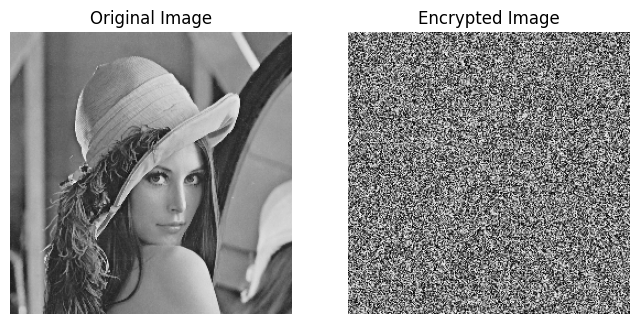

In [6]:
original_image = cv2.imread("./images/Lena-Image.png")
encrypted_image = cv2.imread(FILE_PATH)

# create figure 
fig = plt.figure(figsize=(8, 4))

# Adds a subplot at the 1st position 
fig.add_subplot(1, 2, 1)

# showing image 
plt.imshow(original_image) 
plt.axis('off') 
plt.title("Original Image") 
  
# Adds a subplot at the 2nd position 
fig.add_subplot(1, 2, 2)
  
# showing image 
plt.imshow(encrypted_image) 
plt.axis('off') 
plt.title("Encrypted Image") 
 

## Diffusion decryption Output and Histograms

In [7]:
def decode_set_vals(x_c, l, val, bound):
    counter = 0
    c = 0
    t = 0

    while counter!=bound:
        c+=1
        x_val = (4*l*x_c)*(1-x_c)

        if(get_encrypted_pixel_val(x_val)==val):
            counter += 1

        x_c = x_val
        t = x_val

    return [c, t]

def decode_pixel(encrypted_px_data, decrypted_px_data, initial_x_c, initial_l, history):

    # Iterating over the pixel data sequentially
    for idx, val in enumerate(encrypted_px_data):
        c, x = decode_set_vals(initial_x_c, initial_l, val, history[idx])
        decrypted_px_data.append(c)

        # chaining the x_c
        initial_x_c = x


In [8]:
# reading the pixel data values for the encrypted image
with Image.open("./images/encrypted-image-1.png", mode='r') as im:

    # original image pixel data is stored in px_data 
    im = ImageOps.grayscale(im)
    epx_data = list(im.getdata())

    print(f'eMin: {min(epx_data)}, eMax: {max(epx_data)}')
    print(f'Encrypted Image resolution: WxH {im.size}\n')

im.close()

# Decrypting the Encrypted Image
decrypted_px_data = []

decode_pixel(epx_data, decrypted_px_data, initial_x_c, initial_l, history)

d = np.reshape(decrypted_px_data, (256, 256))

# Saving the decrypted image
DECODED_FILE_PATH = './images/decrypted-image-1.png'

# converting the pixel data into greyscale image
db = Image.fromarray(d).convert("L")

db.save(DECODED_FILE_PATH)

eMin: 0, eMax: 255
Encrypted Image resolution: WxH (256, 256)



Text(0.5, 1.0, 'Decrypted Image')

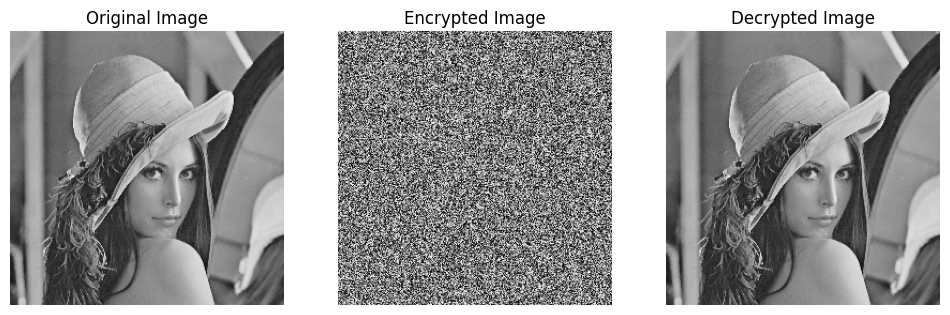

In [9]:
# Plotting all the three images(Original, Encrypted and Decrypted) for comparison purposes
original_image = cv2.imread("./images/Lena-Image.png")
encrypted_image = cv2.imread(FILE_PATH)
decrypted_image = cv2.imread(DECODED_FILE_PATH)

# create figure 
fig = plt.figure(figsize=(12, 4))

# Adds a subplot at the 1st position 
fig.add_subplot(1, 3, 1)

# showing image 
plt.imshow(original_image) 
plt.axis('off') 
plt.title("Original Image") 
  
# Adds a subplot at the 2nd position 
fig.add_subplot(1, 3, 2)
  
# showing image 
plt.imshow(encrypted_image) 
plt.axis('off') 
plt.title("Encrypted Image")

# Adds a subplot at the 3rd position 
fig.add_subplot(1, 3, 3)
  
# showing image 
plt.imshow(decrypted_image) 
plt.axis('off') 
plt.title("Decrypted Image")
